In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, image
%matplotlib inline
from IPython.display import Image
import PIL as PIL

## Lecture - Image Compression and Principal Component Analysis

### Learning objectives

- Learn how to decompose a matrix using the Singular Value Decompostion (SVD)
- Learn how to perform image compression with the SVD
- Learn about Principal Component Analysis (PCA)
- Understand how PCA can be applied to a dataset

## 1. Melt ponds 

Melt ponds, also called supraglacial lakes, are bodies of water that form on the surface of a glacier or an ice sheet. During the Antarctic summer melt season, between November and February, meltwater accumulates in hollows and cracks on the ice sheet. These melt ponds are important because meltwater has a lower *albedo* than ice, so they can locally increase surface melt in a positive feedback loop. Also, while melt ponds will often refreeze at the end of the melt season, they can sometimes drain through to the ice sheet bed, which can cause basal sliding and short-term acceleration of the ice sheet. Finally, melt ponds can cause hydrofracture, a process which occurs when meltwater fills and expands vertical crevasses, triggering fracturing. Hydrofracture can lead to ice sheet disintegration (Fricker et al, 2020). 

The impacts of melt ponds on ice sheets are not fully understood. Since these melt ponds exist in very remote areas, satellite remote sensing is the most realistic and useful tool to gather information for analysis of melt ponds. 

## 2. Satellite data 

### 2.1 Sentinel-2 satellites
The Sentinel-2 mission consists of a pair of two identical satellites, Sentinel-2A and Sentinel-2B. Both of these satellites carry a high-resolution multispectral imager (MSI) instrument with 13 spectral bands (USGS EROS Archive). Part of the ESA's Copernicus program, the Sentinel-2A satellite was launched in June 2015, with the Sentinel-2B satellite launched in March 2017. These two satellites operate in a sun-synchronous orbit, phased 180$^\circ$ from each other, at a mean altitude of 786 km (ESA). The Sentinel-2 satellites have a repeat cycle of 10 days (meaning they collect images of the same location on the Earth every 10 days) and provide data from a 290-km wide swath with either 60 m, 20 m, or 10 m resolution. 

### 2.2 Data product and retrieval
The data collected by Sentinel-2 is freely available; we can retrieve it using the Copernicus Open Access Hub. In this notebook, we will use the Level-2A data product, which consists of bottom-of-atmosphere reflectances that are already orthorectified and map-projected and do not need additional preprocessing. For this example, I retrieved data gathered above Amery Ice Shelf in Antarctica that shows melt ponds studied by Fricker et al. (2020). 

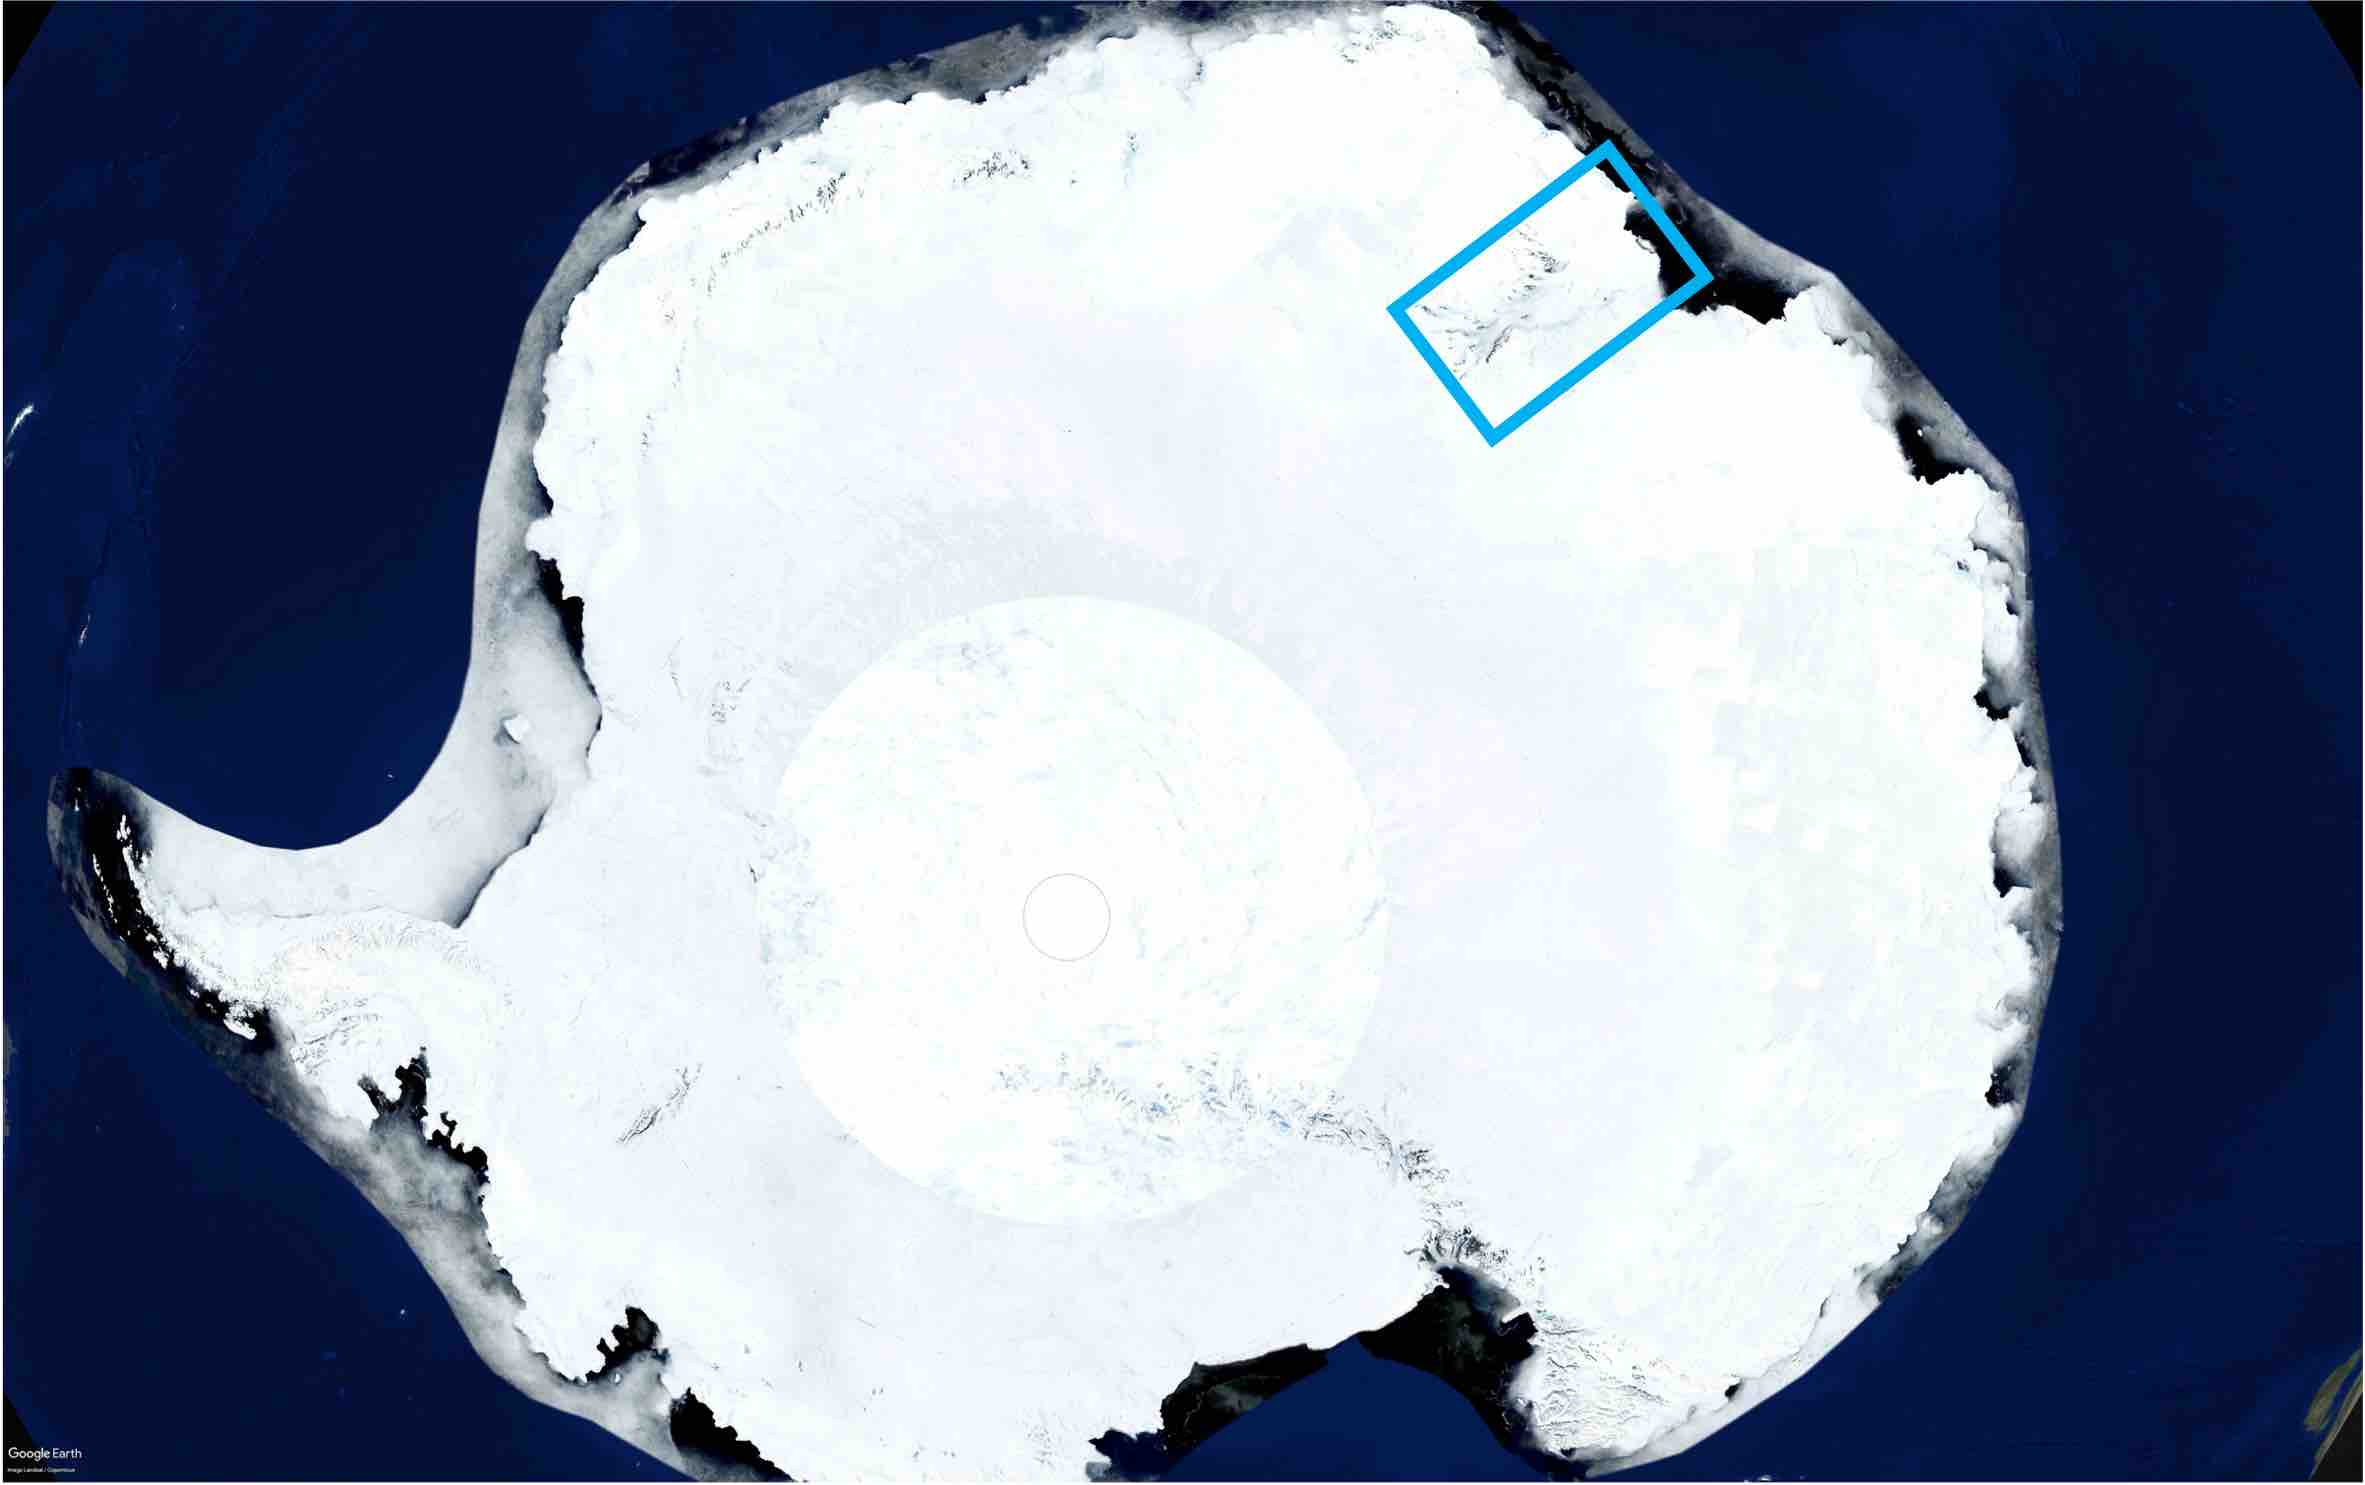

In [2]:
Image(filename='Figures/where_is_amery_antarctica.jpg')

## 3. Loading and trimming the satellite data 

First we load in the data. The 13 bands are stored in separate .csv files, which we will load those into a single large array (actually an `ndarray`). 
It's a lot of data, so have zipped rach raw csv files. 
The 13 data files are located in `Datasets/pca` and have the file extension `.gz`.
For convenience below we provide you with list containing all the filenames.

In [3]:
filenames = ["Datasets/pca/AOT_data.csv.gz", "Datasets/pca/b2_data.csv.gz",  "Datasets/pca/b3_data.csv.gz",  \
             "Datasets/pca/b4_data.csv.gz",  "Datasets/pca/b5_data.csv.gz",  "Datasets/pca/b6_data.csv.gz",  \
             "Datasets/pca/b7_data.csv.gz",  "Datasets/pca/b8A_data.csv.gz", "Datasets/pca/b11_data.csv.gz", \
             "Datasets/pca/b12_data.csv.gz", "Datasets/pca/SCL_data.csv.gz", "Datasets/pca/TCI_data.csv.gz", \
             "Datasets/pca/WVP_data.csv.gz"]

We wish to pack the content from all 12 files into a single 3D `ndarray` with dimensions $M \times N \times 13$.
Each `.gz` file contain the same amount of data (i.e. the same number of rows and columns).
We will open the first file to determine what the sizes $M$ and $N$, using `numpy.getfromtext()`.
Luckily for us `numpy.getfromtext()` will recongize that the filename ends with `.gz` and auto-magically unzip the data for us.

In [4]:
aot = np.genfromtxt('Datasets/pca/AOT_data.csv.gz', delimiter=',')
len_a1, len_a2 = aot.shape
len_a3 = len(filenames) # len_a3 will equal 13

In [5]:
data_full = np.zeros((len_a1, len_a2, len_a3))
for k in range((len(filenames))):
    data_full[:, :, k] = np.genfromtxt(filenames[k], delimiter=',')

We should check the size of the data array we've created. 

In [6]:
print('Size of data_full:', data_full.shape) 

Size of data_full: (435, 460, 13)


Now we can plot the RGB bands of the data, to take a look at what we have. From the documentation (USGS EROS Center Archive, Sentinel-2) we know that the red, green and blue bands are stored in bands 4, 3, and 2 respectively. 

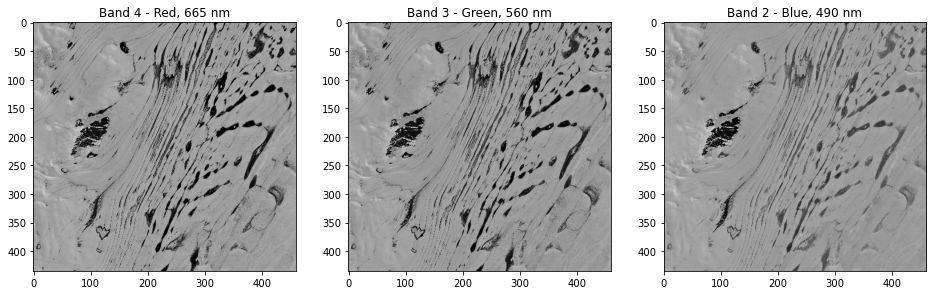

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(data_full[:, :, 4], cmap=cm.gray)
plt.title('Band 4 - Red, 665 nm')

plt.subplot(1, 3, 2)
plt.imshow(data_full[:, :, 3], cmap=cm.gray)
plt.title('Band 3 - Green, 560 nm')

plt.subplot(1, 3, 3)
plt.imshow(data_full[:, :, 2], cmap=cm.gray)
plt.title('Band 2 - Blue, 490 nm')
plt.show()

These bands look quite similar, and we can tell that there is both areas of ice (lighter grey areas) and areas that are not ice (darker grey/black areas) in the image. But at a glance, we don't know what those darker areas are. 

To simplify our analysis a bit, let's look at one specific area of the data. ICESat-2 data (Fricker et al., 2020)
tells us that there is a melt pond here, and we want to examine this melt pond in our analysis later.  

First we extract the region defined by the pixels within the range $i = [0, 100]$ and $j = [120, 200]$.

In [8]:
data = data_full[0:100, 120:200, :]
print('Size of extracted region:', data.shape)

Size of extracted region: (100, 80, 13)


Now we plot the extracted region

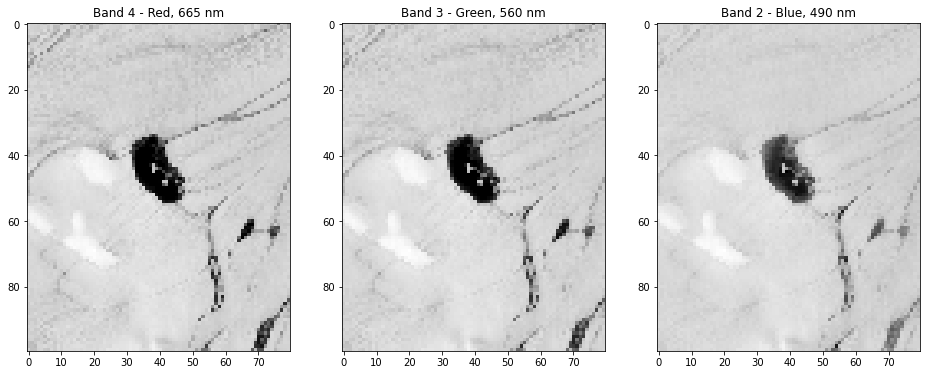

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(data[:, :, 4], cmap=cm.gray)
plt.title('Band 4 - Red, 665 nm')

plt.subplot(1, 3, 2)
plt.imshow(data[:, :, 3], cmap=cm.gray)
plt.title('Band 3 - Green, 560 nm')

plt.subplot(1, 3, 3)
plt.imshow(data[:, :, 2], cmap=cm.gray)
plt.title('Band 2 - Blue, 490 nm')
plt.show()

Wow, now we can see this melt pond close up! We can also see some features of the ice sheet. 

## 4. Efficient image compression using the SVD

Images are a common example of a large data set that we may wish to compress. The idea behind this is that an image is a large data set containing patterns that we can represent with a much smaller amount of data. (Some of you may have encountered image compression before in daily life, if you've emailed or texted a picture to someone and found that the image was compressed (and the quality lowered) so that the image would fit in the message). 

We can perform image compression by organizing our image data as a matrix with elements corresponding to pixels. Then we can take the Singular Value Decomposition (SVD) of this matrix. But what is the SVD?

### 4.1 Singular Value Decomposition (SVD)

The SVD is a type of **matrix decomposition**, which is where a matrix is factorized into a product of matrices. If we have a data matrix $\mathbf{X}$, we can compute the singular value decomposition to factorize $\mathbf{X}$ into three matrices, $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T$. The columns of the matrix $\mathbf{U}$ are the left **singular vectors** of $\mathbf{X}$, and the columns of the matrix $\mathbf{V}$ are the right **singular vectors** of $\mathbf{X}$. Also, $\mathbf{\Sigma}$ is a diagonal matrix that contains the **singular values** of $\mathbf{X}$. 

Throughout this notebook, we use the notation $\mathbf{V}^T$ to mean the transpose of the matrix $\mathbf{V}$. This means the rows of $\mathbf{V}$ become the columns of $\mathbf{V}^T$. We've seen how to tranpose matrices before, using `np.transpose()`. 

We can use the `numpy.linalg.svd()` function to compute the SVD of an input matrix. This function returns three outputs: `U`, a 2D array representing the matrix of left singular vectors of the input matrix, `Sigma`, a 1D array containing the singular values of the input matrix, and `Vt`, a 2D array representing the tranpose of the matrix of right singular vectors of the input matrix. When using `numpy.linalg.svd()` we have two options: we can perform the **Full SVD**, or if the data matrix $\mathbf{X}$ is rectangular, we can compute the **Reduced SVD** which is quicker. In the following examples, we will use the full SVD by passing the option `full_matrices = True`, or the reduced SVD by passing the option `full_matrices = False`, into `numpy.linalg.svd()`. 

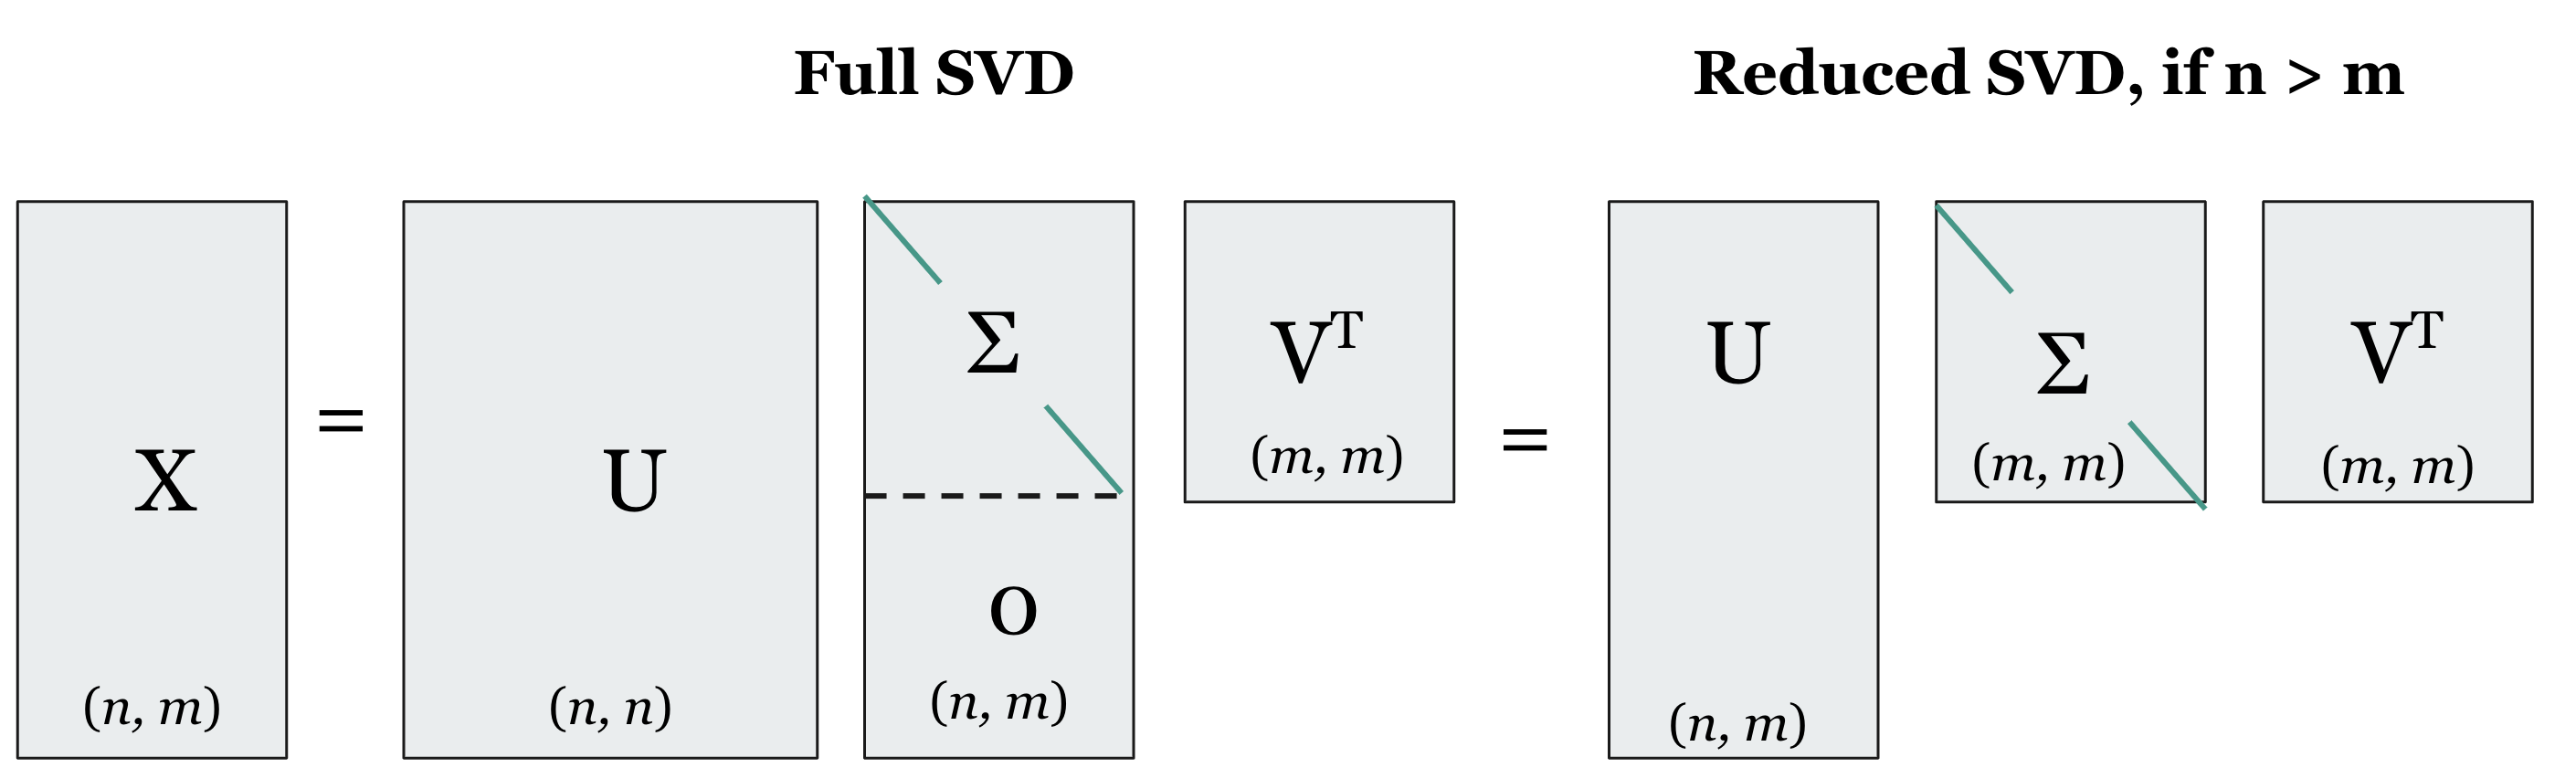

In [10]:
Image(filename='Figures/full_and_reduced_SVD.png')

Figure adapted from S. Brunton and N. Kutz, Data Driven Science and Engineering, 2019. Chapter 1, SVD.

One nice property of the SVD is that it is guaranteed to exist for any matrix. 

### 4.2 Compression via SVD

If we want to compress an image, we can store that image data as a matrix and then compute the SVD. We then create an approximation of the image of rank $r$ by multiplying the first $r$ left singular vectors (i.e. the first $r$ columns of $\mathbf{U}$) with the first $r$ singular values (i.e. the first $r$ columns of $\mathbf{\Sigma}$) and the first $r$ right singular vectors (i.e. the first $r$ columns of $\mathbf{V}$). So our approximated image matrix $\mathbf{X}_r$ can be expressed:

$\mathbf{X}_r = \mathbf{U}_r \mathbf{\Sigma}_r \mathbf{V}^T_r$. 

where:

$\mathbf{U}_r$ contains the first $r$ left singular vectors (in code, this is `U[:, 0:r]`), 

$\mathbf{\Sigma}_r$ is a diagonal matrix with the first $r$ singular values along the diagonal (in code, this is `np.diag(Sigma[0:r])`), and

$\mathbf{V}^T_r$ contains the first $r$ right singular vectors (in code, this is `Vt[0:r, :]`). 

We're going to want to perform compression via SVD a few times at different ranks $r$ of approximation, so writing a function will be helpful. In `low_rank_approximation()`, we compute `frac`, which is the fraction of the variability of the data matrix that is explained by the approximation. The higher the fraction, the more variability is being explained - ideally, we would like a high fraction with a low rank $r$ approximation. 

In [11]:
def low_rank_approximation(U, Sigma, Vt, r):
    '''
    Performs a low-rank reconstruction and computes the fraction
    of information contained within the low-rank approximation.
    
    Input:
      U : ndarray : first arg returned from np.linalg.svd()
      Sigma : ndarray : second arg returned from np.linalg.svd()
      Vt : ndarray : third arg returned from np.linalg.svd()
      r : int : rank
    Returns:
      X_r : ndarray : low-rank approximation to X = U Sigma V^T
      frac : float : fraction of information contained in X_r
    '''
    
    # Define low-rank approximations of U, Sigma, Vt
    U_r     = U[:, 0:r]
    Sigma_r = np.diag(Sigma[0:r]) # Note that we have to form a diagonal matrix from Sigma[] using np.diag()
    Vt_r    = Vt[0:r, :]
    
    # Compute X_r = U_r Sigma_r V^T_r
    X_r = np.matmul(np.matmul(U_r, Sigma_r), Vt_r) # np.matmul() multiplies two matrices together
    
    frac = np.sum(Sigma[0:r]) / np.sum(Sigma) # Estimated information content of X_r
    return X_r, frac

## 5. Compressing the Amery Ice Sheet data

Let's apply image compression to one of the bands of our Amery Ice Sheet data. We'll choose the red band, but we could perform this process on any bands, or indeed any picture we wished. 

In [12]:
red_band = data[:, :, 4] # Pull out band 4, red
print('Size of red_band:', red_band.shape) # Check what size it is

Size of red_band: (100, 80)


So we have our image data in a matrix (e.g. a NumPy `ndarray`). Now we can use the SVD to obtain the singular values and singular vectors we need to use for our reconstructions. 

In [13]:
U, Sigma, Vt = np.linalg.svd(red_band, full_matrices=False)
print('Size of U:     ', U.shape)
print('Size of Sigma: ', Sigma.shape)
print('Size of V^T:   ', Vt.shape)

Size of U:      (100, 80)
Size of Sigma:  (80,)
Size of V^T:    (80, 80)


Now let's create several low-rank approximations for the red band of our data using `low_rank_approximation()`.
Specifically we will consider the ranks given by $r = 1, 10, 40, 60, 80$.

In [14]:
# Define the target ranks
r_vals = [1, 10, 40, 60, len(Sigma)]

# Initialize arrays full of zeros in which to store our results
Xr = np.zeros((red_band.shape[0], red_band.shape[1], len(r_vals)))
frac = np.zeros(len(r_vals))

In [15]:
# Now iterate through r_vals[] and call low_rank_approximation()
for i in range(len(r_vals)):
    r = r_vals[i]
    Xr[:, :, i], frac[i] = low_rank_approximation(U, Sigma, Vt, r)

Now that we've computed a few different approximations, let's take a look at the results. 

We pack the values of `r_vals` and `frac` into a `dict` using dictionary comprehension

In [16]:
result = { r_vals[i]: frac[i]  for i in range(len(r_vals)) }

And now we view it

In [17]:
print('rank : %information\n', result)

rank : %information
 {1: 0.5471856593669718, 10: 0.7600486695804961, 40: 0.9368581235534433, 60: 0.983489812640659, 80: 1.0}


Even our very low rank approximations $r = 10$ is explaining over 76% of the variability in the image.

It makes sense that the fraction is one for our rank 80 approximation, because if we use all 80 singular values and singular vectors, we are recovering our original matrix and in fact not approximating at all. But it's always good to check this. 

Now lets plot the low-rank data matrices $\mathbf{X}_r$ for $r = 1, 10, 40, 60, 80$.

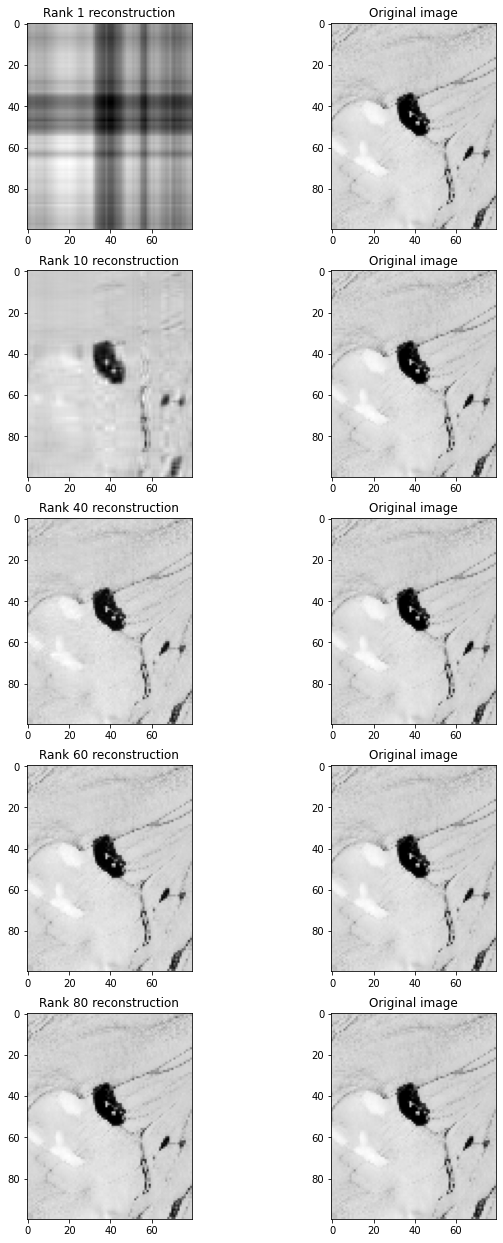

In [18]:
plt.figure(figsize=(10, 22))

nranks = len(r_vals)
panel_id = 1
for i in range(nranks):
    plt.subplot(nranks, 2, panel_id) # We will plot the reconstructed Xr next to X
    plt.imshow(Xr[:, :, i], cmap=cm.gray)
    plt.title('Rank ' + str(r_vals[i]) + ' reconstruction')
    panel_id += 1
    
    plt.subplot(nranks, 2, panel_id)
    plt.imshow(red_band, cmap=cm.gray)
    plt.title('Original image')
    panel_id += 1

### 5.1 Compressing a different image

Now let's see how image compression works on a different image. We'll use `PIL.Image.open()` to load in the Google Earth image of Antarctica we saw earlier. 

In [19]:
img_rgb = PIL.Image.open('Figures/where_is_amery_v4.jpg')

In [20]:
print('img_rbg type:', type(img_rgb))

img_rbg type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


The data stored in `img_rbg` is a JPEG image and can be visualized using `plt.imshow()`.

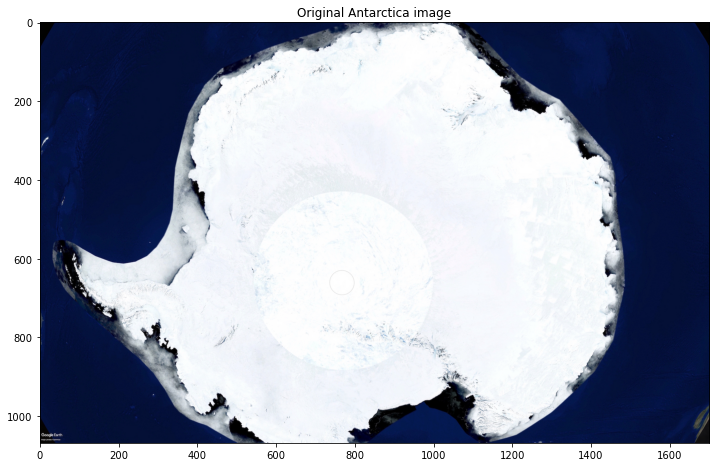

In [21]:
plt.figure(figsize=(12, 12))
plt.title('Original Antarctica image')
plt.imshow(img_rgb);

Here we are interested in extracting the raw arrays of data representing the underlying RGB (red, green, blue) colors defining this image. We can do this by passing `img_rgb` as the input to `np.array()`.

In [22]:
img_rgb_vals = np.array(img_rgb)
print('img_rgb_vals type:', type(img_rgb_vals))
print('img_rgb_vals size:', img_rgb_vals.shape)

img_rgb_vals type: <class 'numpy.ndarray'>
img_rgb_vals size: (1068, 1701, 3)


Let's pull out the RBG bands so we can approximate them. 

In [23]:
img_r = img_rgb_vals[:, :, 0]
img_g = img_rgb_vals[:, :, 1]
img_b = img_rgb_vals[:, :, 2]

Now we want to take the SVD and form approximations of different resolutions, for each of our bands.

First, taking the SVD of each band (the cell below will take a while to run due to the size of the data matrix):

In [24]:
U_red,   Sigma_red,   Vt_red   = np.linalg.svd(img_r, full_matrices=False)
U_green, Sigma_green, Vt_green = np.linalg.svd(img_g, full_matrices=False)
U_blue,  Sigma_blue,  Vt_blue  = np.linalg.svd(img_b, full_matrices=False)

Let's start with a rank 1 approximation. 

In [25]:
r = 1
Xr_red,   frac_r = low_rank_approximation(U_red,   Sigma_red,   Vt_red,   r)
Xr_green, frac_g = low_rank_approximation(U_green, Sigma_green, Vt_green, r)
Xr_blue,  frac_b = low_rank_approximation(U_blue,  Sigma_blue,  Vt_blue,  r)

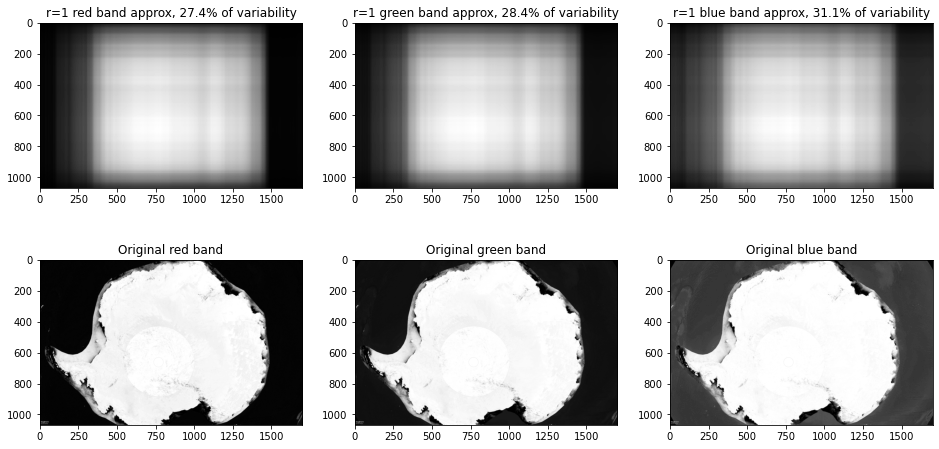

In [26]:
plt.figure(figsize=(16, 8))

plt.subplot(2,3,1)
plt.imshow(Xr_red, cmap=cm.gray)
plt.title('r=' + str(r) + ' red band approx, ' + str(round(frac_r*100, 1)) + '% of variability')
plt.subplot(2,3,2)
plt.imshow(Xr_green, cmap=cm.gray)
plt.title('r=' + str(r) + ' green band approx, ' + str(round(frac_g*100, 1)) + '% of variability')
plt.subplot(2,3,3)
plt.imshow(Xr_blue, cmap=cm.gray)
plt.title('r=' + str(r) + ' blue band approx, ' + str(round(frac_b*100, 1)) + '% of variability')

plt.subplot(2, 3, 4)
plt.imshow(img_r, cmap=cm.gray)
plt.title('Original red band')
plt.subplot(2, 3, 5)
plt.imshow(img_g, cmap=cm.gray)
plt.title('Original green band')
plt.subplot(2, 3, 6)
plt.imshow(img_b, cmap=cm.gray)
plt.title('Original blue band');

The rank 1 approximation explains about 30% of the variability in our image. But our approximations aren't really recognizable as Antarctica, so we're going to increase the rank. 

In [27]:
r = 10
Xr_red,   frac_r = low_rank_approximation(U_red,   Sigma_red,   Vt_red,   r)
Xr_green, frac_g = low_rank_approximation(U_green, Sigma_green, Vt_green, r)
Xr_blue,  frac_b = low_rank_approximation(U_blue,  Sigma_blue,  Vt_blue,  r)

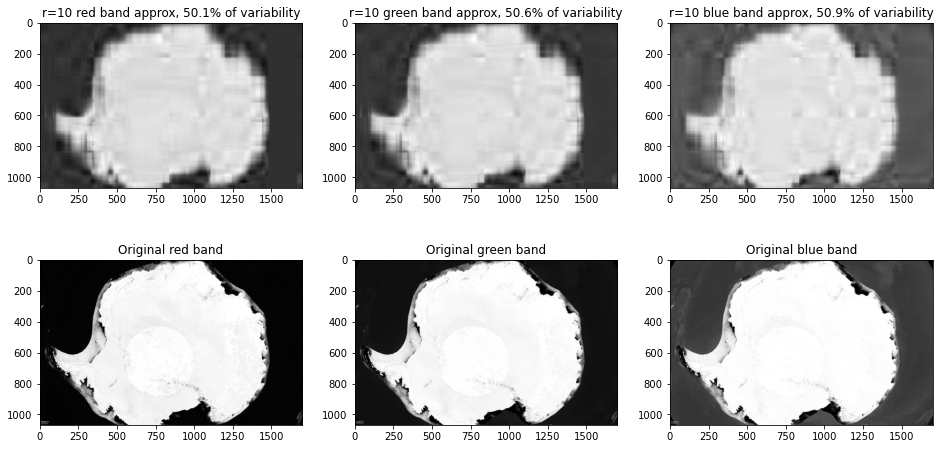

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.imshow(Xr_red, cmap=cm.gray)
plt.title('r=' + str(r) + ' red band approx, ' + str(round(frac_r*100, 1)) + '% of variability')
plt.subplot(2,3,2)
plt.imshow(Xr_green, cmap=cm.gray)
plt.title('r=' + str(r) + ' green band approx, ' + str(round(frac_g*100, 1)) + '% of variability')
plt.subplot(2,3,3)
plt.imshow(Xr_blue, cmap=cm.gray)
plt.title('r=' + str(r) + ' blue band approx, ' + str(round(frac_b*100, 1)) + '% of variability')

plt.subplot(2, 3, 4)
plt.imshow(img_r, cmap=cm.gray)
plt.title('Original red band')
plt.subplot(2, 3, 5)
plt.imshow(img_g, cmap=cm.gray)
plt.title('Original green band')
plt.subplot(2, 3, 6)
plt.imshow(img_b, cmap=cm.gray)
plt.title('Original blue band');

It's starting to look like Antarctica. Let's try a rank 200 image reconstruction.

In [29]:
r = 200
Xr_red,   frac_r = low_rank_approximation(U_red,   Sigma_red,   Vt_red,   r)
Xr_green, frac_g = low_rank_approximation(U_green, Sigma_green, Vt_green, r)
Xr_blue,  frac_b = low_rank_approximation(U_blue,  Sigma_blue,  Vt_blue,  r)

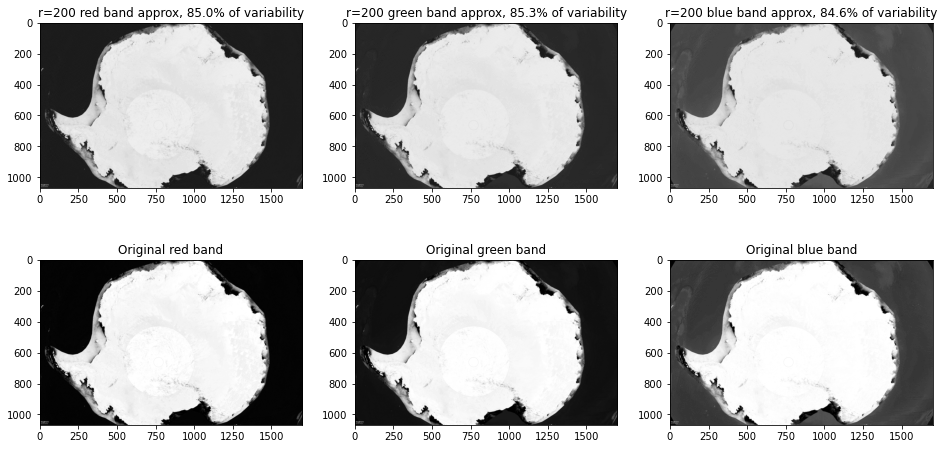

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.imshow(Xr_red, cmap=cm.gray)
plt.title('r=' + str(r) + ' red band approx, ' + str(round(frac_r*100, 1)) + '% of variability')
plt.subplot(2, 3, 2)
plt.imshow(Xr_green, cmap=cm.gray)
plt.title('r=' + str(r) + ' green band approx, ' + str(round(frac_g*100, 1)) + '% of variability')
plt.subplot(2, 3, 3)
plt.imshow(Xr_blue, cmap=cm.gray)
plt.title('r=' + str(r) + ' blue band approx, ' + str(round(frac_b*100, 1)) + '% of variability')

plt.subplot(2, 3, 4)
plt.imshow(img_r, cmap=cm.gray)
plt.title('Original red band')
plt.subplot(2,3,5)
plt.imshow(img_g, cmap=cm.gray)
plt.title('Original green band')
plt.subplot(2, 3, 6)
plt.imshow(img_b, cmap=cm.gray)
plt.title('Original blue band');

This looks good, and we're explaining ~85% of the variability in the image. Now we can stack our approximated bands together using the function `np.stack()`, which joins together arrays along the axis we specify. In this case, specifying `axis=2` will give us a 3D array of size (3013, 4800, 3), where the 3rd dimension is size 3 because we have 3 bands. We use our stacked bands to form an rgb image and compare it to our original image. The PIL library can help us do this. However, `PIL.image.fromarray()` is expecting data ranging from 0 to 255, and we have data outside of that range. So we need to rescale. Also, it is expecting data of type `uint8`. 

In [31]:
data_stack = np.stack([Xr_red, Xr_green, Xr_blue], axis=2)
print('Max of data_stack before rescaling:', np.max(data_stack))
print('Min of data_stack before rescaling:', np.min(data_stack))

# Determine bounding box
min_data, max_data = np.min(data_stack), np.max(data_stack)
# Determine interval
ds = max_data - min_data
# rescale data
data_stack -= min_data
data_stack /= (ds/255)

print('Max of data_stack after rescaling:', np.max(data_stack))
print('Min of data_stack after rescaling:', np.min(data_stack))

Max of data_stack before rescaling: 284.6313695549597
Min of data_stack before rescaling: -31.557741707679746
Max of data_stack after rescaling: 255.00000000000003
Min of data_stack after rescaling: 0.0


Now we create an in-memory representation of a JPEG using our stacked data

In [32]:
approx_rbg_img = PIL.Image.fromarray(data_stack.astype(np.uint8))
print('approx_rbg_img type:', type(img_rgb))

approx_rbg_img type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


and finally we plot and compare the low-rank approximate image with the original image.

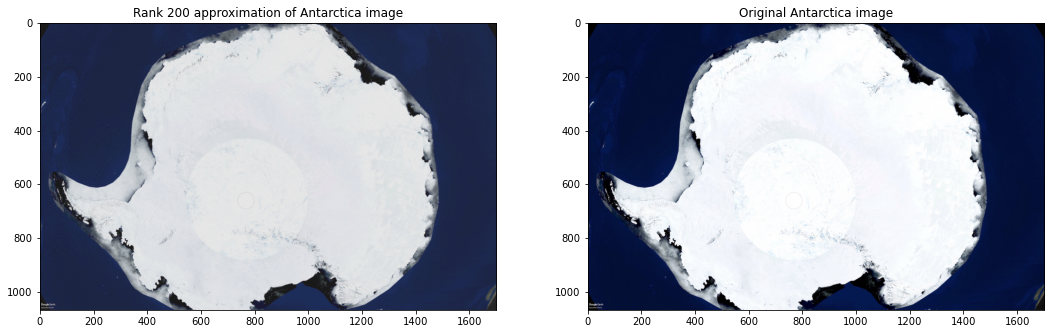

In [33]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.title('Rank ' + str(r) + ' approximation of Antarctica image');
plt.imshow(approx_rbg_img);

plt.subplot(1, 2, 2)
plt.title('Original Antarctica image')
plt.imshow(img_rgb);

### 5.2 Compression ratio

To measure the efficiency of our approximate image, we will compute something called the compression ratio.
The measures the ratio of the amount of data required to repreresnt the original image, compared with the amount of data required to represent the approximate image.

The original data matrix had the following dimensions

In [34]:
print(img_rgb_vals.shape)

(1068, 1701, 3)


Thus the amount of data required to be stored to represent it is

In [35]:
n_entires_orig = img_rgb_vals.shape[0] * img_rgb_vals.shape[1] * img_rgb_vals.shape[2]

The amount of data required by the rank `r` approximate image is found by inspecting the number of entries of each $\mathbf U_r$, $\mathbf \Sigma_r$, $\mathbf V^T_r$ for each of the color (RGB).
Since there are three color bands, the total amount of data is

In [36]:
# n_entires_lowrank = (num entries in U_r) + (num entries in \Sigma_r) + (num entries in V^T_r) x 3
n_entires_lowrank = ((U_red.shape[0] * r) + (r) + (r * Vt_red.shape[1]))*3

In [37]:
print('data compression ratio:', n_entires_orig/n_entires_lowrank)

data compression ratio: 3.279184115523466


Great! - Our approximate RGB image using a rank $r = 200$ requires three times less storage compared to the original RGB image.

## 6. Principal Component Analysis

### 6.1 What is PCA?

Principle Component Analysis is a widely used statistical technique that reduces the dimensionality of a dataset while preserving as much variability as possible (Jolliffe and Cadima, 2016). This method takes a dataset and finds new variables that are linear functions of those in the given dataset, such that the new variables maximize variance and are uncorrelated. 

One of the strengths of PCA is that it is a non-parametric method of analysis, and therefore is not reliant on *a priori* knowledge of the distribution of the data, or the structure of the underlying system (Shlens, 2005). 

### 6.2 The PCA process

Consider a dataset with $n$ observations of $p$ numerical variables, compiled into an $n \times p$
data matrix $\mathbf{X}$, the $j$-th column of which is a vector of observations on the $j$-th variable (following the notation of Jolliffe and Cadima, 2016). This data matrix $\mathbf{X}$ is centered, which means subtracting the mean of each column from that column. The aim is to find a linear combination $\mathbf{X} \mathbf{a}$ of the columns of $\mathbf{X}$ that has maximum variance, where $a$ is a vector of constants. 

To get a well-defined solution, we require that the vectors $\mathbf{a}$ have unit norms. In the standard PCA approach, we would find the linear combination with maximum variance by solving an eigenvalue problem for the covariance matrix $\mathbf{S}$ of the centered data matrix. But we can solve an equivalent problem using the powerful tool we've just learned about - the SVD! If we take the SVD of $\mathbf{X}$, we can then use the singular vectors and singular values to recover the principal components (Jolliffe and Cadima, 2016). 

Since the power of PCA lies in dimensionality reduction, it is typical to try and measure how much variance is explained by a given PC, or given set of PCs. Usually, a certain number of PCs are chosen based on what percentage of the total variability they explain. 

### 6.3 PCA with the SVD, step by step
Applied to image data from Sentinel-2, the PCA methodology will generally follow the
following steps.
- Compose the data into a matrix
- Center the data by subtracting the mean of each column from that column
- Compute the SVD of the data matrix
- Create the appropriate linear combinations to obtain principal components

## 7. Applying PCA to our satellite data

Our satellite data has 13 bands which must be composed into a 2D array. Each column of the array will correspond to one of the 13 bands, flattened. 

In [38]:
data_PCA = data[:, :, 0].flatten()
for k in range(1, data.shape[2]):
    data_PCA = np.vstack((data_PCA, data[:, :, k].flatten()))
data_PCA = data_PCA.T
print('Size of data:          ', data.shape)
print('Size of flattened data:', data_PCA.shape)

Size of data:           (100, 80, 13)
Size of flattened data: (8000, 13)


It is necessary to center the data before starting the PCA process. This means subtracting the mean of each column from that column. 

In [39]:
data_cent = data_PCA - np.mean(data_PCA, axis=0)

Now we can compute the SVD of our centered data matrix. 

In [40]:
U, Sigma, Vt = np.linalg.svd(data_cent, full_matrices=False)
print('Size pf U:    ', U.shape)
print('Size of Sigma:', Sigma.shape)
print('Size of V^T:  ', Vt.shape)

Size pf U:     (8000, 13)
Size of Sigma: (13,)
Size of V^T:   (13, 13)


To obtain our principal components, we want to scale each band of our data by the right singular vectors. That is, we wish to compute $\mathbf P = \mathbf X \mathbf V$, where $\mathbf X$ is given by `data_PCA` and $\mathbf V$ is given by `Vt.transpose()` (or equivalent statements `Vt.T`, `np.transpose(Vt)`).

In [41]:
P = np.matmul(data_PCA, Vt.transpose())

We have computed our 13 principal components in `P`. 
However, before we can visualize them using `plt.imshow()`, we have to first undo the process of "flattening" the data which was used to transform the variable `data` into `data_PCA`.
To achieve this, we can use `np.reshape()` with the new shape defined by `data.shape`.

In [42]:
P = np.reshape(P, newshape=data.shape)

And now for the plots where we visualize the 13 principal components

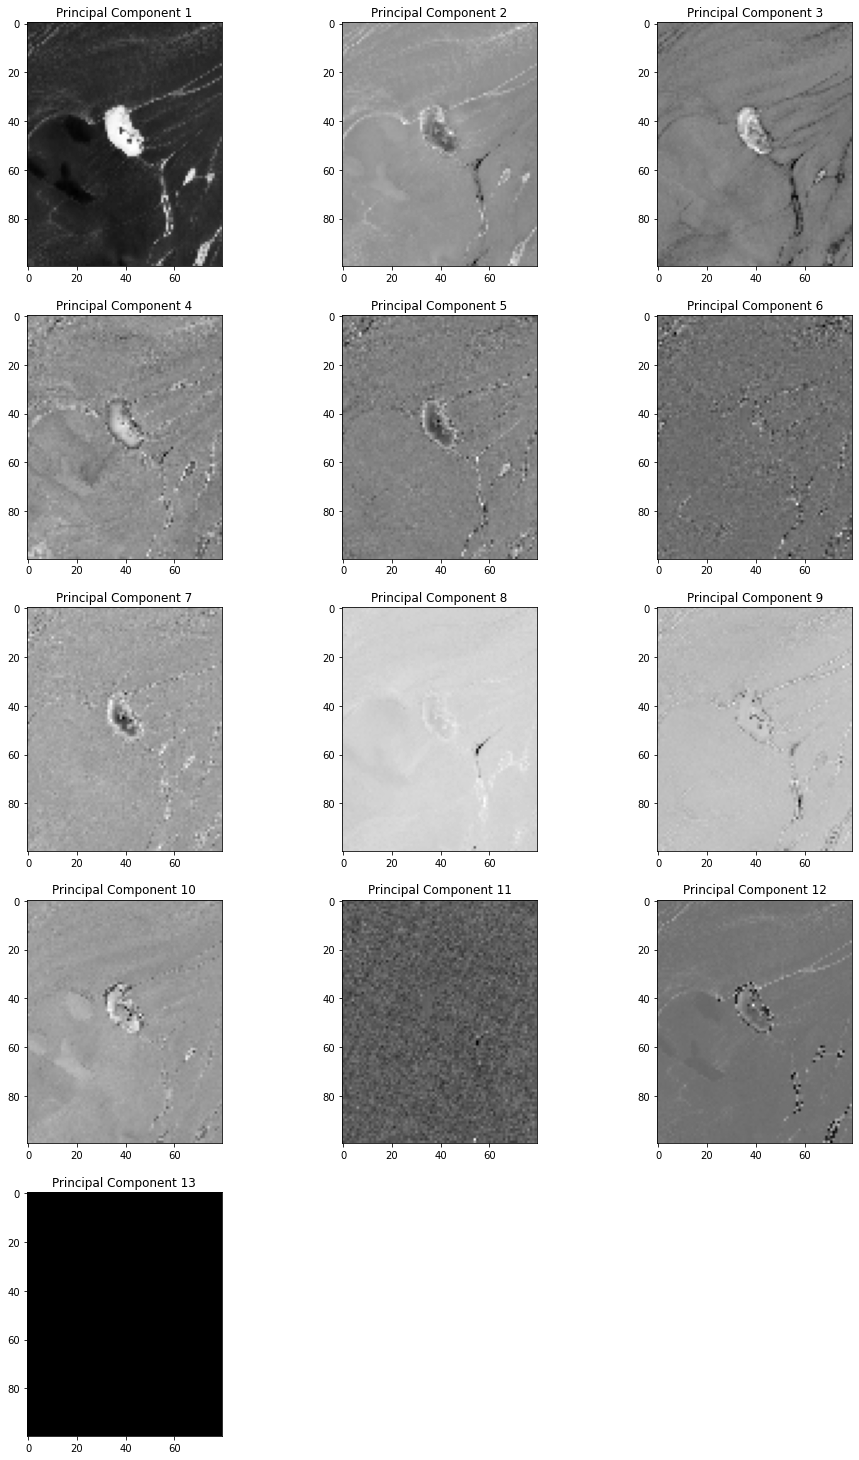

In [43]:
plt.figure(figsize=(16, 26))
for i in range(data.shape[2]):
    plt.subplot(5, 3, i+1)
    plt.imshow(P[:, :, i], cmap=cm.gray, vmin=np.min(np.min(P[:, :, i])), vmax=np.max(np.max(P[:, :, i])))
    plt.title('Principal Component ' + str(i+1))

Principal Component 1 is interesting - it shows a stark difference between the melt pond (in white) and the surrounding ice sheet. How might we get a rough estimate of melt pond surface area from this principal component? 

Principal Component 8 also tells us something that may be physically meaningful. It differentiates between the melt pond (light colors) and the small dark area to the lower right of the melt pond. This may indicate to us that the dark area is not melt, but instead exposed rock or something else. 

## References

- Fricker, H. A., Arndt, P., Brunt, K.M., Datta, R. T., Fair, Z., Jasinski, M.F., et al. (2020). ICESat-2 meltwater depth estimates: Application to surface melt on Amery Ice Shelf, East Antarctica. *Geophysical Research Letters, 48*, e2020GL090550. https://doi.org/10.1029/2020GL090550

- USGS Earth Resources Observation and Science (EROS) Center Archive. Sentinel-2. https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects 

- The European Space Agency (ESA). Missions: Sentinel-2. https://sentinel.esa.int/web/sentinel/missions/sentinel-2 

- Jolliffe, I.T., Cadima, J. (2016). Principal component analysis: a review and recent developments. Phil. Trans. R. Soc. A 374: 20150202. http://dx.doi.org/10.1098/rsta.2015.0202 

- Shlens, J. (2005). A tutorial on Principal Component Analysis. https://arxiv.org/abs/1404.1100 
